In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
## sklearn.preprocessing.Imputer -> sklearn.impute.SimpleImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
import os


os.chdir('/Users/a420777/dl_mlops/what_if/notebooks/house/matt')

### Load housing data

df_train = pd.read_csv("../../../data/raw/house/train.csv")
df_test = pd.read_csv("../../../data/raw/house/test.csv")

## convert numeric to string
df_train["MSSubClass"] = df_train["MSSubClass"].apply(str)
df_train['YrSold'] = df_train['YrSold'].apply(str)
df_train['MoSold'] = df_train['MoSold'].apply(str)

### Missing Data

df_na = (df_train.isnull().sum() / len(df_train)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending = False)
missing_data = pd.DataFrame({"Missing Ratio": df_na})

df_na_cols = pd.DataFrame(df_train.dtypes)
missing_data = missing_data.join(df_na_cols, how = 'left')

# missing_data


## Target analysis
### Distribution of target is skewed -> Log transform

### Fill missing value

## Fill with the supplied value
def fill_missing(df, cols, val):
    for col in cols:
        df[col] = df[col].fillna(val)
        
## Fill with the mode
def fill_missing_with_mode(df, cols):
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])
        
## log transform for columns
def add_log(res, cols):
    m = res.shape[1]
    for col in cols:
        res = res.assign(newcol = pd.Series(np.log(1.01 + res[col])).values)
        res.columns.values[m] = col + '_log'
        m +=1
    
    return res



cat_null_cols = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu","GarageType", "GarageFinish", "GarageQual", "GarageCond",
                 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                "MasVnrType", "MSSubClass", "Electrical"]

num_null_cols = ['GarageYrBlt', 'MasVnrArea']

fill_missing(df_train, cat_null_cols, "None")
fill_missing(df_train, num_null_cols, 0)

# house co located are similar in size
df_train['LotFrontage'] = df_train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

### Add new feature

## total square feet
df_train["TotalSF"] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']

## Modeling(EBM)

# interpretml EBM
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree

X = df_train.drop(['Id', 'SalePrice'], axis= 1)
y = df_train.SalePrice

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state= 42)

marginal = Marginal().explain_data(X_train, y_train, name = 'Train Data')
# show(marginal)

In [3]:
# Explainable boosting regressor
ebm = ExplainableBoostingRegressor(random_state= 42)
ebm.fit(X_train, y_train)


 #performance
from interpret.perf import RegressionPerf
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_valid, y_valid, name = 'EBM')
# show(ebm_perf)

# ebm globa
ebm_global = ebm.explain_global(name = 'EBM')
# show(ebm_global)

In [3]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# scores_range=(-98365.92454651206, 102145.65757499124)

def create_time_series(df, colname):
    
    dff=df[df.col_name==colname]
    trace1 = go.Line(
        x=dff['names'],
        y=dff['scores'],
        name='scores',
        marker=dict(
            color='rgb(34,163,192)',
            size=1),
        line_shape="vh",
        line_dash="solid"
    )
    trace2 = go.Scatter(
        x=dff['names'],
        y=dff['upper_bounds'],
        name='upper_bounds',
        marker=dict(
            color='rgb(12,100,100)',
            size=0.1),
        line_shape="vh",
        line_dash="solid"
    )
    
    trace3 = go.Scatter(
        x=dff['names'],
        y=dff['lower_bounds'],
        name='lower_bounds',
        marker=dict(
            color='rgb(200,1,100)',
            size=0.1),
        line_shape="vh",
        line_dash="solid"
    )
    
    fig = make_subplots()
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.add_trace(trace3)

    fig.update_xaxes(showgrid=False)
    fig.update_layout(height=400,width=400*1.618) # , yaxis_range=list(scores_range))
#     fig.show()
    
    return fig

# # import copy
# global_internal_obj=copy.deepcopy(ebm_global._internal_obj)



In [4]:
import utils

global_df=utils.get_global_df(X_train, ebm)

score_df=utils.get_score_variance_table(global_df, ebm)

appended_df=utils.append_prediction(X_train, ebm)

fi_df=utils.get_feature_importance_df(X_train, ebm)

/Users/a420777/dl_mlops/what_if/notebooks/house/matt/utils.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["prediction"]=model.predict(X)


# local feature

In [5]:
ebm_local = ebm.explain_local(X_valid.iloc[:10], y_valid.iloc[:10], name='EBM')
# show(ebm_local)

In [6]:
show(ebm_local)

<!-- http://127.0.0.1:7561/140263090438800/ -->

In [7]:
local_internal_obj=ebm_local._internal_obj

In [8]:
local_info_list=[]

In [9]:
local_data=local_internal_obj["specific"]

In [10]:
for i in range(len(local_data)):
    col_names=X_train.columns.tolist()

    tar=local_data[i]
    scores=tar['scores'][:len(col_names)]
    values=tar['values'][:len(col_names)]
    
    intercept_score=tar['extra']["scores"][0]
    actual_score=tar['perf']['actual_score']
    predicted_score=tar['perf']['predicted_score']
    
    col_names.append("val_name")
    
    empty=pd.DataFrame(columns=col_names)
    
    scores.append("scores")

    empty.loc[0]=scores

    values.append("values")

    empty.loc[1]=values


    empty["predicted_score"]=predicted_score
    empty["actual_score"]=actual_score
    empty["intercept_score"]=intercept_score
    
    local_info_list.append(empty)

In [20]:
local_df=pd.concat(local_info_list,axis=0)

ValueError: No objects to concatenate

In [12]:
classes=[1,2]
students=[2,3]
for i,j in (classes, students):
    print(i,j)

1 2
2 3


In [90]:
vis_array=local_df[local_df.val_name=="scores"].drop(["val_name","predicted_score","actual_score","intercept_score"],axis=1).iloc[1]

In [91]:
vis_df=pd.DataFrame(vis_array)

In [92]:
vis_df.columns=["contribution"]

In [93]:
vis_df=vis_df.sort_values("contribution",ascending=False)

In [94]:
intercept=local_internal_obj["specific"][0]["extra"]["scores"][0]

In [95]:
abs_top_k_colnames=vis_df.apply(abs).sort_values("contribution").tail(40).index

In [96]:
vis_df_top=vis_df[vis_df.index.isin(abs_top_k_colnames)]

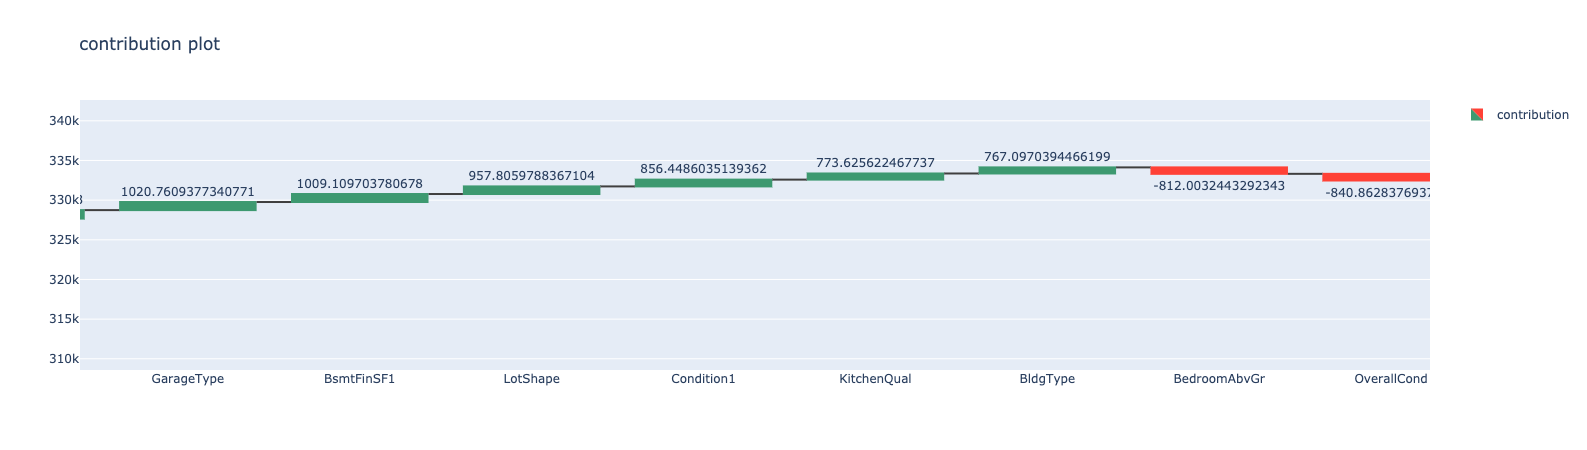

In [105]:
import plotly.graph_objects as go

fig = go.Figure(go.Waterfall(
    base=intercept,
    name = "contribution", orientation = "v",
#     measure = ["relative", "relative", "total", "relative", "relative", "total"],
    x = vis_df_top.index,
    textposition = "outside",
    text = vis_df_top.contribution,
    y = vis_df_top.contribution,
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = "contribution plot",
        showlegend = True
)

fig.show()